In [ ]:
import ROOT as R
import numpy as np
import psutil
import os
import gc

pid = os.getpid()
py = psutil.Process(pid)

print(py.memory_info())

Testing reshape to find GetIndex function:

In [ ]:
a = np.array([[[1, 2], [3, 4]], [[5, 6], [7, 8]]])
print(a,'\n')
print(a[0],'\n')
print(a[0,0],'\n')
print(a[0,0,0])

In [ ]:
nx = 3
ny = 4
nz = 5
b = np.arange(nx*ny*nz)
print(b)
c = b.reshape(nx,ny,nz)
print(c)
# print(c[0,0,0])#z,y,x
print(c[1,0,0])#z
print(c[0,1,0])#y
print(c[0,0,1])#x

In [ ]:
def find_index(ix,iy,iz,nx,ny,nz):
    part_tau_direction = nz*iy
    part_pf_direction  = iz
    part_fe_direction  = nz*ny*ix
    return part_fe_direction + part_pf_direction + part_tau_direction

In [ ]:
ix,iy,iz = 2,3,4
print(c[ix,iy,iz])
print(b[find_index(ix,iy,iz,nx,ny,nz)])

## Read data with header:

In [ ]:
import ROOT as R
import numpy as np

If the kernel dies by running the next line, run this line in a separate .py in the terminal. This will show you the errors:

In [ ]:
R.gInterpreter.ProcessLine('#include "DataLoader.h"')

In [ ]:
n_tau = 10
n_pf  = 5
n_fe  = 30
n_counts = 2

In [ ]:
data_loader = R.DataLoader('/data/store/reco_skim_v1/tau_DYJetsToLL_M-50.root', n_tau)  

In [ ]:
data = data_loader.LoadNext()
n_batches = data_loader.NumberOfBatches()

In [ ]:
def generator():
    while True:
        data_loader.Reset()
        while data_loader.HasNext():
            data = data_loader.LoadNext()
            x_np = np.asarray(data.x)
            x_3d = x_np.reshape((n_tau, n_pf, n_fe))
            y_np = np.asarray(data.y)
            y_2d = y_np.reshape((n_tau, n_counts))
            yield x_3d, y_2d

### Some tests:

In [ ]:
x_np = np.asarray(data.x)
print(x_np)

In [ ]:
n_fe  = 3
n_tau = 4
n_pf  = 2
x_3d = x_np.reshape((n_tau, n_pf, n_fe))
print(x_3d)

In [ ]:
x_3d[1, 1, :]

In [ ]:
d = 1
f = 9
print(type((d,f)))

In [ ]:
(x,y) = next(generator())

In [ ]:
print((x,y),'\n')
print((x[0,0,:],y[0,:]))

In [ ]:
print(y)

In [ ]:
y = np.array([[1,0],[0., 0.],[0., 1.],[0., 0.],[0., 1.],[0., 0.],[0., 1.],[0., 0.],[0., 1.],[0., 0.]])

## Build model:

In [ ]:
import tensorflow as tf

In [ ]:
inputs = tf.keras.Input(shape=(n_pf,n_fe))

In [ ]:
x_inputs = tf.keras.layers.Dense(4, activation=tf.nn.relu)(inputs)

In [ ]:
outputs = tf.keras.layers.Dense(2, activation=tf.nn.relu)(x_inputs)

In [ ]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(optimizer="Adam", loss="mse", metrics=["mae"])

fit(
    x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None,
    validation_split=0.0, validation_data=None, shuffle=True, class_weight=None,
    sample_weight=None, initial_epoch=0, steps_per_epoch=None,
    validation_steps=None, validation_batch_size=None, validation_freq=1,
    max_queue_size=10, workers=1, use_multiprocessing=False
)

In [ ]:
model.fit(x = tf.data.Dataset.from_generator(generator,(tf.float32, tf.float32),(tf.TensorShape([None,5,30]), tf.TensorShape([None,2]))), epochs = 1, steps_per_epoch = n_batches)

In [ ]:
tf.__version__

### Implement model as a class

In [ ]:
import tensorflow as tf

In [ ]:
class MyModel(tf.keras.Model):

  def __init__(self):
    super(MyModel, self).__init__()
    self.dense1 = tf.keras.layers.Dense(4, activation=tf.nn.relu)
    self.dense2 = tf.keras.layers.Dense(2, activation=tf.nn.relu)

  def call(self, inputs):
    x_inputs = self.dense1(inputs2)
    return self.dense2(x_inputs)

model2 = MyModel()

In [ ]:
model2.compile(optimizer="Adam", loss="mse", metrics=["mae"])

In [ ]:
model2.fit(x = generator,epochs = 1, steps_per_epoch = n_batches)

# Working model

In [1]:
import ROOT as R
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

R.gInterpreter.ProcessLine('#include "DataLoader.h"')

Welcome to JupyROOT 6.22/02


0

In [2]:
n_tau = 10
n_pf  = 2
n_fe  = 2
n_counts = 2
n_epochs = 10

data_loader = R.DataLoader('/data/store/reco_skim_v1/tau_DYJetsToLL_M-50.root', n_tau, 0, 1000)
data = data_loader.LoadNext()
n_batches = data_loader.NumberOfBatches()

## Functions:

In [3]:
def generator():
    while True:
        data_loader.Reset()
        while data_loader.HasNext():
            data = data_loader.LoadNext()
            x_np = np.asarray(data.x)
            x_3d = x_np.reshape((n_tau, n_pf, n_fe))
            y_np = np.asarray(data.y)
            y_2d = y_np.reshape((n_tau, n_counts))
            yield x_3d, y_2d

In [4]:
def plot_metrics(history, n_epochs):
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    mse = hist["mae"]
    acc = hist["accuracy"]

    fig, axes = plt.subplots(2, sharex=False, figsize=(12, 8))
    fig.suptitle('Training Metrics')
    axes[0].set_ylabel("Loss", fontsize=14)
    axes[0].set_xlabel("Epoch", fontsize=14)
    axes[0].set_xticks(np.arange(0, n_epochs, 1.0))
    axes[0].plot(epochs, mse, 'bo', label="Loss")
    axes[1].set_ylabel("Accuracy", fontsize=14)
    axes[1].set_xlabel("Epoch", fontsize=14)
    axes[1].set_xticks(np.arange(0, n_epochs, 1.0))
    axes[1].plot(epochs, acc, 'ro', label="Loss")
    plt.show()

### Model:

In [5]:
# Model construction:
class MyModel(tf.keras.Model):

    def __init__(self):
        super(MyModel, self).__init__()
        self.flatten = tf.keras.layers.Flatten() #flattens a ND array to a 2D array
        self.dense1 = tf.keras.layers.Dense(4, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(2, activation=tf.nn.relu)

    def call(self, x):
        x = self.flatten(x)
        x = self.dense1(x)
        return self.dense2(x)

In [ ]:
model = MyModel()

In [ ]:
model.compile(optimizer="Adam", loss="mse", metrics=["mae","accuracy"])

In [ ]:
history = model.fit(x = tf.data.Dataset.from_generator(generator,\
                                            (tf.float32, tf.float32),\
                                            (tf.TensorShape([None,n_pf,n_fe]), tf.TensorShape([None,n_counts]))), \
                                            epochs = n_epochs, steps_per_epoch = n_batches)

model.summary()

In [ ]:
plot_metrics(history, n_epochs)

### Evaluate the model with a test set:

In [ ]:
data_loader = R.DataLoader('/data/store/reco_skim_v1/tau_DYJetsToLL_M-50.root', n_tau,1000,1100)
data = data_loader.LoadNext()
n_batches = data_loader.NumberOfBatches()

model.evaluate(x = tf.data.Dataset.from_generator(generator,\
                                                (tf.float32,tf.float32),\
                                                (tf.TensorShape([None,n_pf,n_fe]),tf.TensorShape([None,n_counts]))),\
                                                   steps = n_batches)

### Get predictions:

In [ ]:
def generator_test():
    while True:
        data_loader.Reset()
        while data_loader.HasNext():
            data = data_loader.LoadNext()
            x_np = np.asarray(data.x)
            x_3d = x_np.reshape((n_tau, n_pf, n_fe))
            yield x_3d

In [ ]:
pred = model.predict(x = tf.data.Dataset.from_generator(generator_test,(tf.float32),\
                                                        (tf.TensorShape([None,n_pf,n_fe]))),steps=1)
#print(pred)

In [ ]:
pred = model.predict(x = tf.data.Dataset.from_generator(generator,\
                                            (tf.float32, tf.float32),\
                                            (tf.TensorShape([None,n_pf,n_fe]), tf.TensorShape([None,n_counts]))), \
                                            steps=1)

In [ ]:
def generator_test_labels():
    while True:
        data_loader.Reset()
        while data_loader.HasNext():
            data = data_loader.LoadNext()
            y_np = np.asarray(data.y)
            y_2d = y_np.reshape((n_tau, n_counts))
            yield y_2d

In [ ]:
# data_test, labels = next(generator())
# print(labels)

In [ ]:
#print(next(generator_test_labels()))
labels = next(generator_test_labels())

In [ ]:
min_range = -5.5
max_range = 5.5
n_bins = int(max_range-min_range)

H0,edges,patches = plt.hist(labels[:,0]-pred[:,0], bins=11, range=(min_range,max_range), \
                        facecolor='red', alpha=0.5, edgecolor='black', linewidth=1.2)
plt.xticks(np.arange(min_range+0.5, max_range+0.5, 1.0))
plt.xlabel('Charged count difference')
plt.ylabel('Number of entries')
plt.show()

H0,edges,patches = plt.hist(labels[:,1]-pred[:,1], bins=n_bins, range=(min_range,max_range), \
                        facecolor='blue', alpha=0.5, edgecolor='black', linewidth=1.2)
plt.xticks(np.arange(min_range+0.5, max_range+0.5, 1.0))
plt.xlabel('Neutral count difference')
plt.ylabel('Number of entries')
plt.show()

### Plot the confusion matrix:

In [ ]:
import seaborn as sns

In [ ]:
edges = np.linspace(0,6,7)
H0,a,b  = np.histogram2d(labels[:,0], pred[:,0],bins=(edges, edges)) #x,y
H1,a,b  = np.histogram2d(labels[:,1], pred[:,1],bins=(edges, edges)) #x,y

In [ ]:
fig1 = plt.figure(figsize=(5,5))
sns.heatmap(H0, cmap='YlGnBu', annot=True, fmt="3.0f")
plt.ylim(0,6)
plt.xlim(0,6)
plt.ylabel('True charge counts',fontsize = 16)
plt.xlabel('Predicted charge counts',fontsize = 16)
plt.show()

fig2 = plt.figure(figsize=(5,5))
sns.heatmap(H1, cmap='YlGnBu', annot=True, fmt="3.0f")
plt.ylim(0,6)
plt.xlim(0,6)
plt.ylabel('True neutral counts',fontsize = 16)
plt.xlabel('Predicted neutral counts',fontsize = 16)
plt.show()

# 4D histogram -> confusion matrix filling -> accurcy extraction

In [90]:
import numpy as np
import seaborn as sns
import ROOT as R
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [106]:
a = np.array([[1,1],[1,1]])
print('a: ',a)
a_bins = [-0.5,0.5,1.5]
H, edges = np.histogramdd(a, bins = (a_bins,a_bins))
print('H: ',H,'\n\n')
print('H[:,0]: ',H[:,1])

a:  [[1 1]
 [1 1]]
H:  [[0. 0.]
 [0. 2.]] 


H[:,0]:  [0. 2.]


In [ ]:
print(type(H))

In [ ]:
r = np.random.randn(100,4)
print(r.shape)
# print(r) #100 linee e 4 colonne
H, edges = np.histogramdd(r, bins = (5, 8, 4, 3))

In [ ]:
print(H)
print('A ', H[:,0],'\n')     #3x4
print('B ', H[:,:,0],'\n')   #2x4
print('C ', H[:,:,:,0],'\n') #2x3

In [ ]:
fig2 = plt.figure(figsize=(5,5))
sns.heatmap(H[0], cmap='YlGnBu', annot=True, fmt="3.0f")
plt.ylim(0,6)
plt.xlim(0,6)
plt.ylabel('True neutral counts',fontsize = 16)
plt.xlabel('Predicted neutral counts',fontsize = 16)
plt.show()

In [6]:
a = np.arange(1,2**4+1,1)
print(a)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [7]:
a = a.reshape(2,2,2,2) #due blocconi di due matrici 2x2
print(a)
print(a.shape)

[[[[ 1  2]
   [ 3  4]]

  [[ 5  6]
   [ 7  8]]]


 [[[ 9 10]
   [11 12]]

  [[13 14]
   [15 16]]]]
(2, 2, 2, 2)


In [8]:
a[:,0,:,0]+a[:,0,:,1]+a[:,1,:,0]+a[:,1,:,1]

array([[14, 22],
       [46, 54]])

In [5]:
b = np.zeros((2,2))
print(b)
for i in range(0,2):
    for j in range(0,2):
        b += a[:,i,:,j]
        print(i,' ',j)
print(b)

[[0. 0.]
 [0. 0.]]
0   0
0   1
1   0
1   1
[[14. 22.]
 [46. 54.]]


In [ ]:
# print('A: ', np.sum(a[0,0,:],axis=0)) # somma prima linea primo blocco
# print('B: ', np.sum(a[0,:,0],axis=0)) # somma prima colonna primo blocco
# print('C: ', np.sum(a[0,1,:],axis=0)) # somma seconda linea primo blocco
# print('D: ', np.sum(a[0,:,1],axis=0)) # somma seconda colonna primo blocco
print('E: ', np.sum(a[0,:,:,:],axis=0)) 
print('F: ', np.sum(a[0,:,:,:],axis=1)) 
print('E: ', np.sum(a[:,0,:,:],axis=0)) 
print('F: ', np.sum(a[:,0,:,:],axis=1)) 
print('E: ', np.sum(a[:,:,0,:],axis=0)) 
print('F: ', np.sum(a[:,:,0,:],axis=1)) 
print('E: ', np.sum(a[:,:,:,0],axis=0)) 
print('F: ', np.sum(a[:,:,:,0],axis=1)) 
print('E: ', np.sum(a[1,:,:,:],axis=0)) 
print('F: ', np.sum(a[1,:,:,:],axis=1)) 
print('E: ', np.sum(a[:,1,:,:],axis=0)) 
print('F: ', np.sum(a[:,1,:,:],axis=1)) 
print('E: ', np.sum(a[:,:,1,:],axis=0)) 
print('F: ', np.sum(a[:,:,1,:],axis=1)) 
print('E: ', np.sum(a[:,:,:,1],axis=0)) 
print('F: ', np.sum(a[:,:,:,1],axis=1)) 

In [11]:
import numpy as np
import seaborn as sns
import ROOT as R
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.22/02


In [17]:
a = np.array([[1,1,1,2],[1,1,2,2],[1,2,2,2],[2,2,2,2]])
print(a)

[[1 1 1 2]
 [1 1 2 2]
 [1 2 2 2]
 [2 2 2 2]]


In [32]:
dm_bins = np.arange(0.5,3.5,1)
print(dm_bins)

[0.5 1.5 2.5]


In [33]:
h, _ = np.histogramdd(a, bins=[dm_bins, dm_bins, dm_bins, dm_bins])

In [35]:
print(h)

[[[[0. 1.]
   [0. 1.]]

  [[0. 0.]
   [0. 1.]]]


 [[[0. 0.]
   [0. 0.]]

  [[0. 0.]
   [0. 1.]]]]


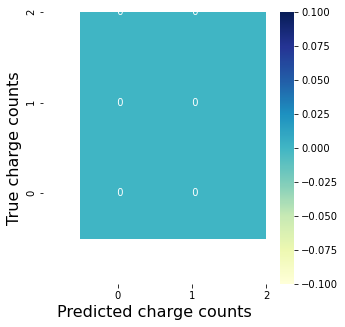

In [26]:
fig10 = plt.figure(figsize=(5,5))
sns.heatmap(h[:,0,:,0], cmap='YlGnBu', annot=True, fmt="3.0f")
plt.ylim(-0.5,2.5)
plt.xlim(-0.5,2.5)
plt.ylabel('True charge counts',fontsize = 16)
plt.xlabel('Predicted charge counts',fontsize = 16)
plt.show()

In [38]:
a = np.array([[1,1],[2,1],[3,1]])
print(a)

[[1 1]
 [2 1]
 [3 1]]


In [79]:
c = np.zeros((3,4))
c[:,0] = a[:,0]*5+a[:,1]
print(c)

[[ 6.  0.  0.  0.]
 [11.  0.  0.  0.]
 [16.  0.  0.  0.]]


In [82]:
b = np.array([1,23,12])
c[:,1] = b
c[:,2] = b+1
c[:,3] = b+2
print(c)

[[ 6.  1.  2.  3.]
 [11. 23. 24. 25.]
 [16. 12. 13. 14.]]


In [88]:
d = np.delete(c,0,0)# elimina la prima linea
d = np.delete(c,1,0)# elimina la seconda linea
d = np.delete(c,0,1)# elimina la prima colonna
d = np.delete(c,1,1)# elimina la seconda colonna
print(d)

[[ 6.  2.  3.]
 [11. 24. 25.]
 [16. 13. 14.]]


In [111]:
a = ([[1.2,2.7,3.55],[7.2,0.9,0.2]])
b = np.round(a,0)
print(b)

[[1. 3. 4.]
 [7. 1. 0.]]


# Physics performance of the model:

In [ ]:
data_loader = R.DataLoader('/data/store/reco_skim_v1/tau_DYJetsToLL_M-50.root', n_tau, 5000, 5500)
n_batches   = data_loader.NumberOfBatches()

In [ ]:
conf_matrix = None
dm_bins = np.arange(-0.5,23.5,1) 
n_steps = 2
count_steps = 0

In [ ]:
for x,y in generator():
    y_pred = model.predict(x)
    yy = np.concatenate((y, y_pred), axis = 1)
    h, _ = np.histogrmdd(yy, bins=[dm_bins, dm_bins, dm_bins, dm_bins])

    if conf_matrix is None:
        conf_matrix = h
    else:
        conf_matrix += h
    
    count_steps += 1

    if count_steps >= n_steps: break